In [1]:
# from patch_CAVI import *
import numpy as np
import matplotlib.pyplot as plt
import torch
from types import SimpleNamespace
import sys
sys.path.append('..')
from field_of_junctions import FieldOfJunctions
import matplotlib
import cv2
from patch_CAVI_unary import *

## CAVI helpers

In [2]:
def func(x):
    x = -x.abs()
    mult = torch.exp(-30.0 * x.max(0, keepdim=True)[0].max(1, keepdim=True)[0] ** 2)
    return mult * 10.0 * torch.exp(3.0 * x)

In [5]:
permutations = patch_multipliers[torch.arange(N).view(-1, 1, 1, 1, 1, 1, 1),
                perm_list.permute(1, 0).view(1, 3, 6, 1, 1, 1, 1),
                torch.arange(1).view(1, 1, -1, 1, 1, 1, 1),
                torch.arange(de.RF).view(1, 1, 1, -1, 1, 1, 1),
                torch.arange(de.RF).view(1, 1, 1, 1, -1, 1, 1),
                torch.arange(H_patches).view(1, 1, 1, 1, 1, -1, 1),
                torch.arange(W_patches).view(1, 1, 1, 1, 1, 1, -1)]

NameError: name 'patch_multipliers' is not defined

## Creating simple FOJ patches

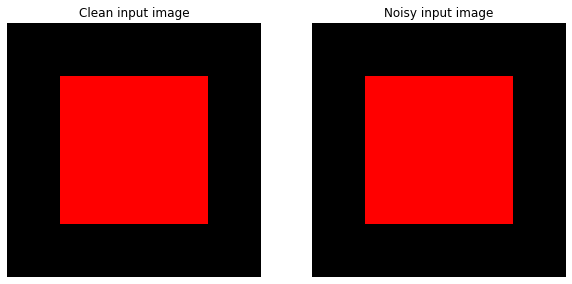

In [3]:
# Red square on black background
clean_img = np.zeros((48, 48, 3), dtype=np.float32)
clean_img[10:-10, 10:-10, 0] = 1.0

# Add noise
img = clean_img + np.random.randn(*clean_img.shape)*0
mn, mx = img.min(), img.max()

# Adjust contrast (equally to both images)
img = (img - mn) / (mx - mn)
clean_img = (clean_img - mn) / (mx - mn)

plt.figure(figsize=[10, 10])
plt.subplot(121)
plt.imshow(clean_img)
plt.title('Clean input image')
plt.axis('off');
plt.subplot(122)
plt.imshow(img)
plt.title('Noisy input image')
plt.axis('off');

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Beginning initialization...
Initialization iteration 0/30
Initialization iteration 5/30
Initialization iteration 10/30
Initialization iteration 15/30
Initialization iteration 20/30
Initialization iteration 25/30
CPU times: user 13min 46s, sys: 13min 12s, total: 26min 59s
Wall time: 4min 52s


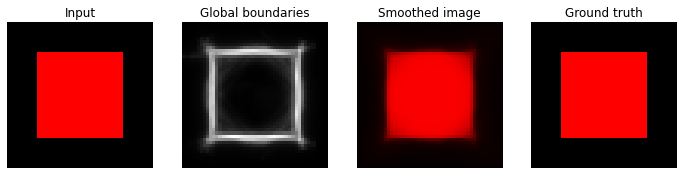

In [4]:
# Create opts object
opts = SimpleNamespace()

opts.R                        = 21
opts.stride                   = 1
opts.eta                      = 0.01
opts.delta                    = 0.05
opts.lr_angles                = 0.003
opts.lr_x0y0                  = 0.03
opts.lambda_boundary_final    = 0.5
opts.lambda_color_final       = 0.1
opts.nvals                    = 31
opts.num_initialization_iters = 30
opts.num_refinement_iters     = 0
opts.greedy_step_every_iters  = 50
opts.parallel_mode            = True
opts.ang_per_vertex           = 3


# Define function for optimization (foj.optimize() may be used instead)
def foj_optimize_verbose():
    for i in range(foj.num_iters):
        if i == 0:
            print("Beginning initialization...")
        if i == opts.num_initialization_iters:
            print("Initialization done. Beginning refinement...")
        if i < opts.num_initialization_iters:
            if i % 5 == 0:
                print(f"Initialization iteration {i}/{opts.num_initialization_iters}")
        else:
            if i % 100 == 0:
                print(f"Refinement iteration {i}/{opts.num_refinement_iters}")
        foj.step(i)

# Create and optimize field of junctions
foj = FieldOfJunctions(img, opts)
%time foj_optimize_verbose()       # Run optimization with some printing

# Compute smoothed image and boundary map
params = torch.cat([foj.angles, foj.x0y0], dim=1)
dists, _, patches = foj.get_dists_and_patches(params)
local_boundaries = foj.dists2boundaries(dists)
global_boundaries = foj.local2global(local_boundaries)[0, 0, :, :].detach().cpu().numpy()
smoothed_img = foj.local2global(patches)[0, :, :, :].permute(1, 2, 0).detach().cpu().numpy()

plt.figure(figsize=[12, 12])
plt.subplot(141)
plt.imshow(img)
plt.title('Input')
plt.axis('off')
plt.subplot(142)
plt.imshow(global_boundaries, cmap='gray')
plt.title('Global boundaries')
plt.axis('off')
plt.subplot(143)
plt.imshow(smoothed_img)
plt.title('Smoothed image')
plt.axis('off')
plt.subplot(144)
plt.imshow(clean_img)
plt.title('Ground truth')
plt.axis('off');

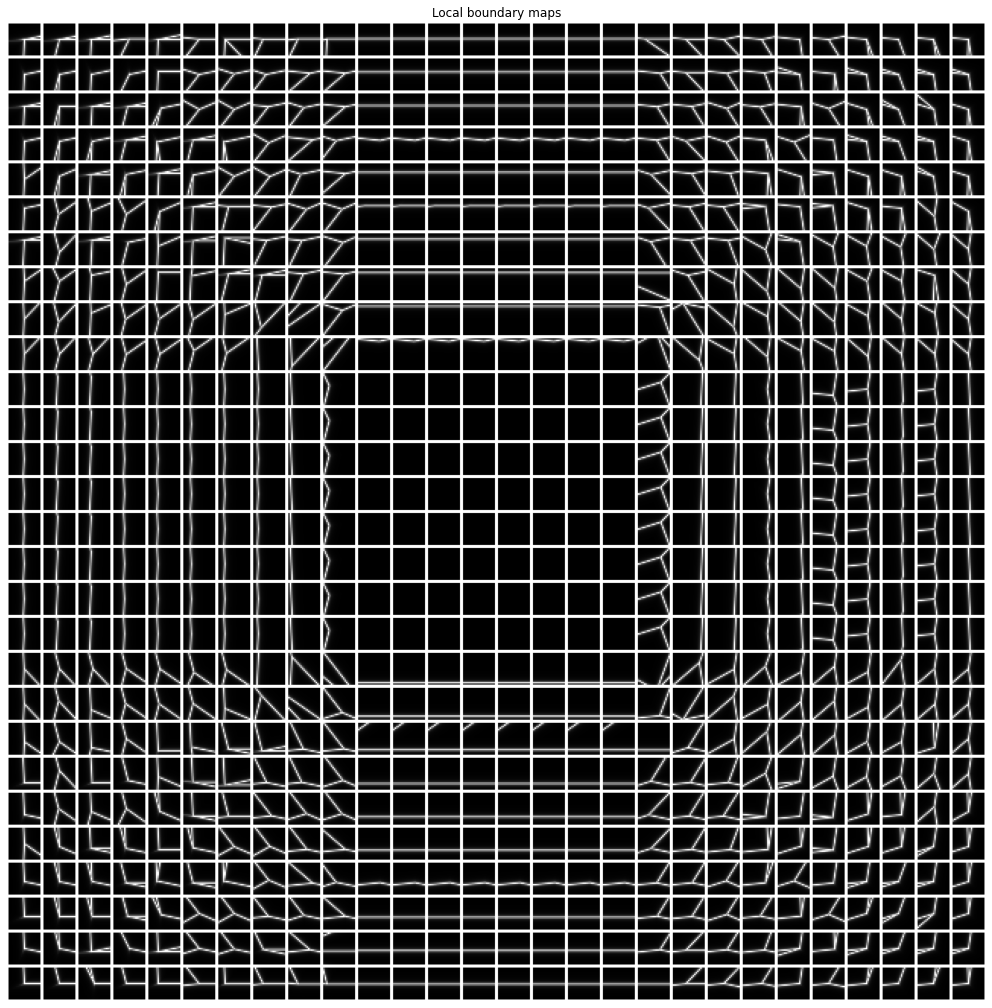

In [5]:
from utils import patchstack

boundary_vis = patchstack(local_boundaries)[0, :, :, :].detach().permute(1, 2, 0).cpu().numpy()
plt.figure(figsize=[18, 18])
plt.imshow(boundary_vis, cmap='gray')
plt.title('Local boundary maps')
plt.axis('off');


In [6]:
angles = torch.remainder(params[:, :3, :, :], 2 * np.pi)
angles = torch.sort(angles, dim=1)[0].detach().cpu().numpy()

t_angle1 = angles[0, 0, :, :]   # shape [N, 1, 1, H', W']
t_angle2 = angles[0, 1, :, :]   # shape [N, 1, 1, H', W']
t_angle3 = angles[0, 2, :, :]  # shape [N, 1, 1, H', W']

#ANGLES ARE SWAPPED BECUASE WEDGES ORDERED COUNTERCLOCKWISE
angle1 = np.remainder(t_angle1-t_angle3,2*np.pi)
angle3 = np.remainder(t_angle2-t_angle1,2*np.pi) 
angle2 = np.remainder(t_angle3-t_angle2,2*np.pi)
anglemat = np.stack((angle1,angle2,angle3),axis = 0)

In [7]:
anglemat.shape

(3, 28, 28)

## Looking at initial wedges and ordering

Vertex position [[-2.625980e+02 -4.048173e-02]]
Original Angles [6.2831855 6.0805025 0.       ]


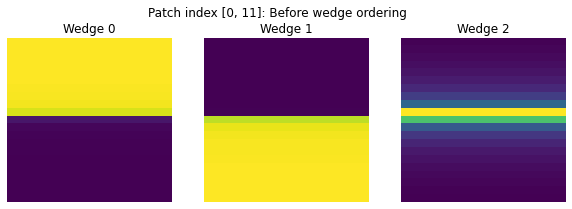

In [8]:
wedges = foj.dists2indicators(dists).detach().cpu().numpy()
# print('wedge shape', wedges.shape)
patch_index = [0,11]
plt.figure(figsize=[10,30])
plt.suptitle(f'Patch index {patch_index}: Before wedge ordering')
plt.subplot(131)
plt.imshow(wedges[0,0,:,:,patch_index[0],patch_index[1]])
plt.title('Wedge 0')
plt.axis('off')
plt.subplot(132)
plt.imshow(wedges[0,1,:,:,patch_index[0],patch_index[1]])
plt.title('Wedge 1')
plt.axis('off')
plt.subplot(133)
plt.imshow(wedges[0,2,:,:,patch_index[0],patch_index[1]])
plt.title('Wedge 2')
plt.axis('off')
plt.subplots_adjust(top=1.73)

angles = params[:, :3, :, :].detach().cpu().numpy()


print('Vertex position', params[:, 3:, patch_index[0],patch_index[1]].detach().cpu().numpy())


print('Original Angles', angles[0,:,patch_index[0],patch_index[1]])

# print('Wedge Angles', anglemat[:,patch_index[0],patch_index[1]])

# plt.colorbar()

# print('Wedge Range', np.min(wedges[0,1,:,:,0,0]),np.max(wedges[0,1,:,:,0,0]))

In [9]:
H_patches = wedges.shape[4]
W_patches = wedges.shape[5]
N=1

In [10]:
#Use wedges to create region patches, use these patches to create permutations

wedges = foj.dists2indicators(dists).detach().cpu()
region_patches = wedges.unsqueeze(1).unsqueeze(3)
permutations = get_permutations(region_patches)

In [232]:
idxs = resolve_permutations_mrf(permutations, stride=1, neighborhood=8, max_iters=None, func=func, func2=func, seed=[0,0])

In [233]:
idxs.shape

torch.Size([28, 28])

In [234]:
perm_list[idxs].shape

torch.Size([28, 28, 3])

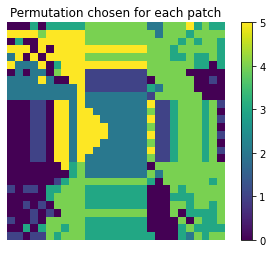

In [235]:
plt.imshow(idxs)
plt.axis('off')
plt.title('Permutation chosen for each patch')
plt.colorbar()
plt.show()

In [236]:
perm_tensor = perm_list[idxs].view(1,1,1,1,H_patches,W_patches,3)
perm_tensor = perm_tensor.repeat(1,1,opts.R,opts.R,1,1,1)
perm_tensor.shape 

torch.Size([1, 1, 21, 21, 28, 28, 3])

In [237]:
perm_list[idxs];

In [238]:
wedges = foj.dists2indicators(dists).detach().cpu()
perm_wedges = wedges.unsqueeze(-1).swapdims(1,6)

In [239]:
perm_wedges.shape

torch.Size([1, 1, 21, 21, 28, 28, 3])

In [240]:
sort_wedges = perm_wedges[0,0,:,:,idxs]

In [241]:
sort_wedges.shape

torch.Size([21, 21, 28, 28, 28, 3])

In [242]:
idxs.shape

torch.Size([28, 28])

In [243]:
test = torch.tensor([0,1,2]).view(1,1,-1).repeat(28,28,1)
test[perm_list[idxs]].shape

torch.Size([28, 28, 3, 28, 3])

In [244]:
sorted_wedges = torch.gather(perm_wedges, -1, perm_tensor)
sorted_wedges = sorted_wedges.swapdims(1,6).squeeze(-1)
sorted_wedges.shape

torch.Size([1, 3, 21, 21, 28, 28])

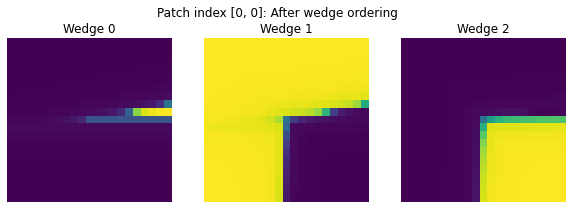

In [245]:

patch_index = [0,0]
plt.figure(figsize=[10,30])
plt.suptitle(f'Patch index {patch_index}: After wedge ordering')
plt.subplot(131)
plt.imshow(sorted_wedges[0,0,:,:,patch_index[0],patch_index[1]])
plt.title('Wedge 0')
plt.axis('off')
plt.subplot(132)
plt.imshow(sorted_wedges[0,1,:,:,patch_index[0],patch_index[1]])
plt.title('Wedge 1')
plt.axis('off')
plt.subplot(133)
plt.imshow(sorted_wedges[0,2,:,:,patch_index[0],patch_index[1]])
plt.title('Wedge 2')
plt.axis('off')
plt.subplots_adjust(top=1.73)


In [142]:
sorted_angles = -1*torch.tensor(np.sort(-anglemat,axis=0))

## Next part: Sort by wedge size

In [246]:
ang_sort_idx = torch.tensor(np.argsort(-anglemat,axis=0))
# angles_ascending = np.take_along_axis(useful_angles, ang_sort_idx, axis=0)
ang_sort_idx = ang_sort_idx.unsqueeze(-1).swapdims(0,3).squeeze(0)
ang_sort_idx = ang_sort_idx.view(1,1,1,1,H_patches,W_patches,3)
ang_sort_idx = ang_sort_idx.repeat(1,1,opts.R,opts.R,1,1,1)
ang_sort_idx.shape

torch.Size([1, 1, 21, 21, 28, 28, 3])

In [247]:
ang_sorted_wedges_resh = torch.gather(perm_wedges, -1, ang_sort_idx)
ang_sorted_wedges = ang_sorted_wedges_resh.swapdims(1,6).squeeze(-1)


In [248]:
ang_region_patches = ang_sorted_wedges.unsqueeze(1).unsqueeze(3)
ang_permutations = get_permutations(ang_region_patches)

In [249]:
ang_idxs = resolve_permutations_mrf(ang_permutations, stride=1, neighborhood=8, max_iters=1000, func=func, func2=func, seed=[15,15])

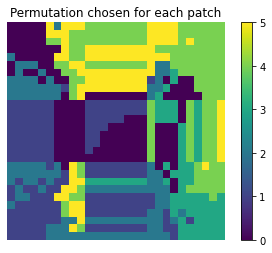

In [250]:
plt.imshow(ang_idxs)
plt.axis('off')
plt.title('Permutation chosen for each patch')
plt.colorbar()
plt.show()

In [251]:
ang_perm_tensor = perm_list[ang_idxs].view(1,1,1,1,H_patches,W_patches,3)
ang_perm_tensor = ang_perm_tensor.repeat(1,1,opts.R,opts.R,1,1,1)

ang_perm_wedges = torch.gather(perm_wedges, -1, ang_perm_tensor)
ang_perm_wedges = ang_perm_wedges_resh.swapdims(1,6).squeeze(-1)



Vertex position [[-2.0259637e-02 -1.4901161e-08]]
Wedge Angles tensor([3.2429, 3.0403, 0.0000])


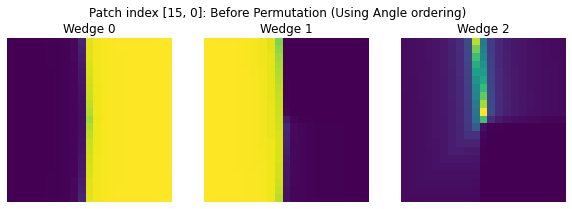

In [288]:
patch_index = [15,0]
plt.figure(figsize=[10,30])
plt.suptitle(f'Patch index {patch_index}: Before Permutation (Using Angle ordering)')
plt.subplot(131)
plt.imshow(ang_sorted_wedges[0,0,:,:,patch_index[0],patch_index[1]])
plt.title('Wedge 0')
plt.axis('off')
plt.subplot(132)
plt.imshow(ang_sorted_wedges[0,1,:,:,patch_index[0],patch_index[1]])
plt.title('Wedge 1')
plt.axis('off')
plt.subplot(133)
plt.imshow(ang_sorted_wedges[0,2,:,:,patch_index[0],patch_index[1]])
plt.title('Wedge 2')
plt.axis('off')
plt.subplots_adjust(top=1.73)
print('Vertex position', params[:, 3:, patch_index[0],patch_index[1]].detach().cpu().numpy())
print('Wedge Angles', sorted_angles[:,patch_index[0],patch_index[1]])

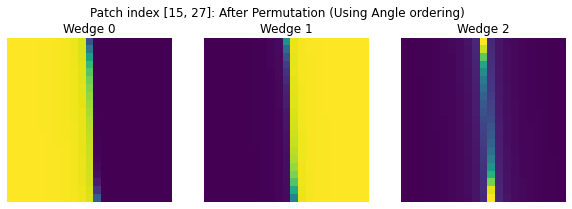

In [255]:
# patch_index = [23,27]
plt.figure(figsize=[10,30])
plt.suptitle(f'Patch index {patch_index}: After Permutation (Using Angle ordering)')
plt.subplot(131)
plt.imshow(ang_perm_wedges[0,0,:,:,patch_index[0],patch_index[1]])
plt.title('Wedge 0')
plt.axis('off')
plt.subplot(132)
plt.imshow(ang_perm_wedges[0,1,:,:,patch_index[0],patch_index[1]])
plt.title('Wedge 1')
plt.axis('off')
plt.subplot(133)
plt.imshow(ang_perm_wedges[0,2,:,:,patch_index[0],patch_index[1]])
plt.title('Wedge 2')
plt.axis('off')
plt.subplots_adjust(top=1.73)


In [256]:
ang_idxs[patch_index[0],patch_index[1]]

tensor(5)

## Creating unary potentials

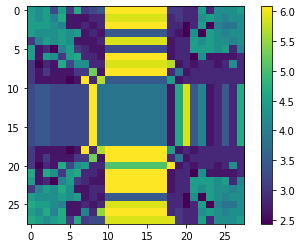

In [143]:
plt.imshow(sorted_angles[0,...].numpy())
plt.colorbar()

In [287]:
sorted_angles = -1*torch.tensor(np.sort(-anglemat,axis=0))
epsilon_0 = .3
epsilon_2 = .3

out_of_bounds = torch.max(torch.abs(foj.x0y0),axis=1)[0].squeeze(0) 
#Booleans representing the conditionals
w0_pi = torch.abs(sorted_angles[0,...]-torch.pi)<epsilon_0
w1_pi = torch.abs(sorted_angles[1,...]-torch.pi)<epsilon_0
w2_zero = sorted_angles[2,...]<epsilon_2

Text(0.5, 1.0, 'Case 3')

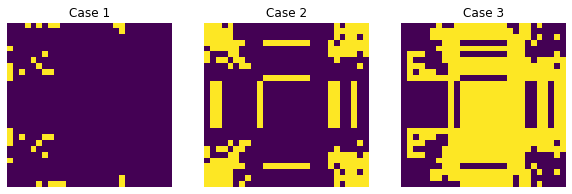

In [292]:
# plt.imshow(w0_pi.numpy())
# plt.imshow((out_of_bounds>1).numpy())
# plt.imshow(out_of_bounds.numpy())

# plt.imshow(w2_zero.numpy())
# torch.sum(w2_zero)


#Locations of Case 1 w0 -> pi, w2 !-> 0
plt.figure(figsize = [10,30])
plt.subplot(131)
plt.imshow(w0_pi.numpy()&  ~w2_zero.numpy()&(out_of_bounds<1).numpy())
plt.axis('off')
plt.title('Case 1')

#Locations of Case 2  w2 -> 0
plt.subplot(132)
plt.imshow(w2_zero.numpy() &~w1_pi.numpy()&(out_of_bounds<1).numpy())
plt.axis('off')
plt.title('Case 2')

#Locations of Case 3  w0 !-> pi, w2 !-> 0
plt.subplot(133)
plt.imshow((~w0_pi.numpy()& ~w2_zero.numpy())|(out_of_bounds>1).numpy())
plt.axis('off')
plt.title('Case 3')

In [293]:
unary_pots = np.zeros((6,*w2_zero.numpy().shape))
unary_pots[:,w0_pi.numpy()& ~w2_zero.numpy()] = np.array([[0,0,1,1,1,1]]).T
unary_pots[:,w2_zero.numpy()] = np.array([[0,0,0,1,1,1]]).T
unary_pots[:,~w0_pi.numpy()& ~w2_zero.numpy()] = np.array([[0,0,0,0,0,0]]).T

#Inverting
unary_pots = np.zeros((6,*w2_zero.numpy().shape)) 
unary_pots[:,w0_pi.numpy()& ~w2_zero.numpy()] = np.array([[1,1,0,0,0,0]]).T
unary_pots[:,w2_zero.numpy()&~w1_pi.numpy()] = np.array([[0,0,1,1,0,1]]).T
unary_pots[:,(~w0_pi.numpy()& ~w2_zero.numpy())|(out_of_bounds>1).numpy()] = np.array([[0,0,0,0,0,0]]).T

In [294]:
unary_pots.shape

(6, 28, 28)

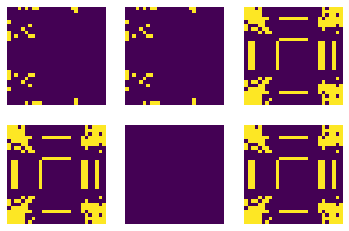

In [295]:
for itr in range(unary_pots.shape[0]):
    plt.subplot(2,3,itr+1)
    plt.imshow(unary_pots[itr,:,:])
    plt.axis('off')

In [345]:
ang_idxs_unary = resolve_permutations_mrf(ang_permutations, stride=1, neighborhood=8, max_iters=1000,unary = .2*unary_pots,  func=func, func2=func, seed=[15,0])

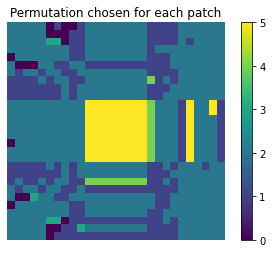

In [346]:
plt.imshow(ang_idxs_unary)
plt.axis('off')
plt.title('Permutation chosen for each patch')
plt.colorbar()
plt.show()

In [347]:
ang_perm_tensor_unary = perm_list[ang_idxs_unary].view(1,1,1,1,H_patches,W_patches,3)
ang_perm_tensor_unary = ang_perm_tensor_unary.repeat(1,1,opts.R,opts.R,1,1,1)

ang_perm_wedges_unary = torch.gather(ang_sorted_wedges_resh, -1, ang_perm_tensor_unary)
ang_perm_wedges_unary = ang_perm_wedges_unary.swapdims(1,6).squeeze(6)


In [348]:
ang_idxs_unary[16,0]
unary_pots[:,16,0]

array([0., 0., 0., 0., 0., 0.])

<ipython-input-349-07bb804dd9ee>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=[10,30])


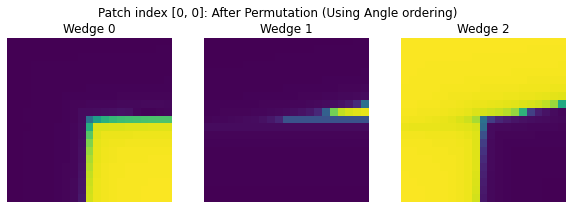

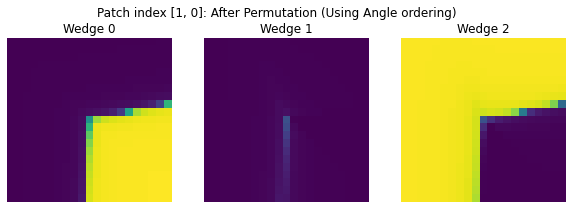

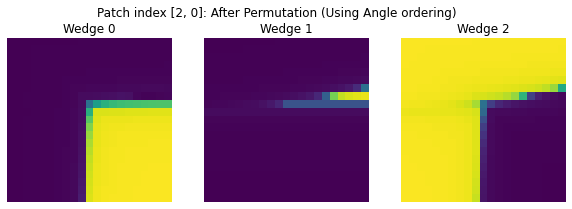

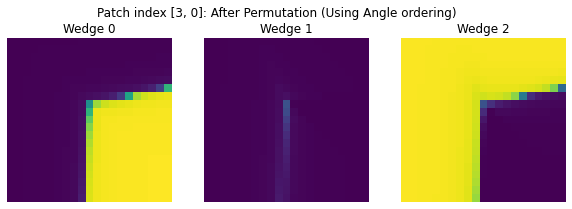

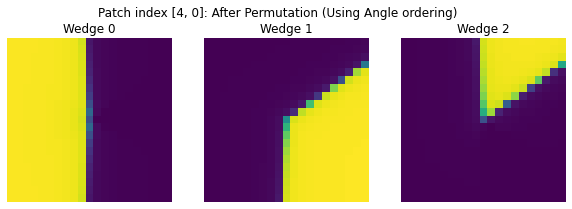

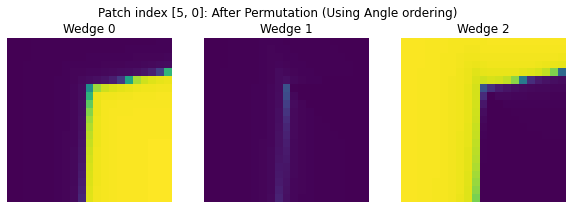

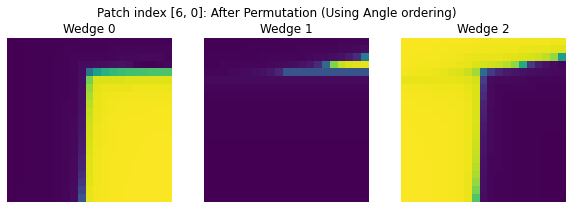

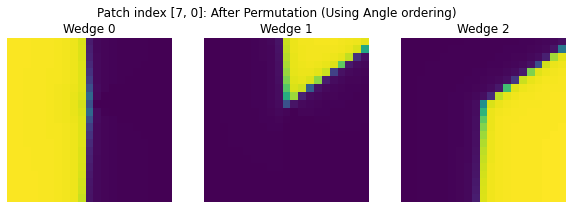

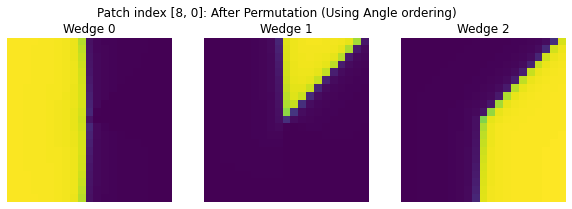

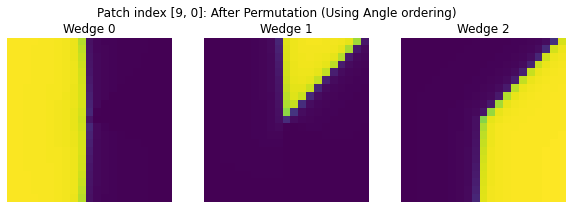

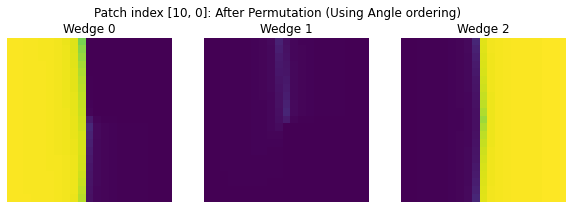

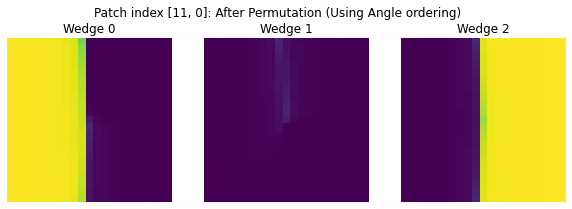

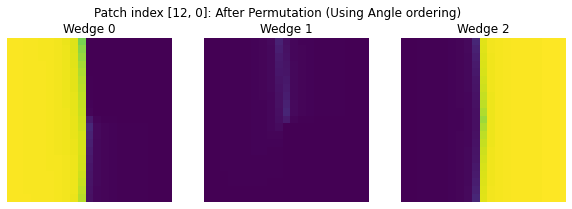

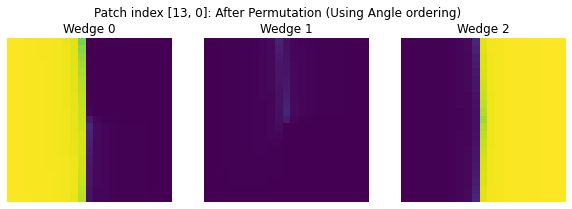

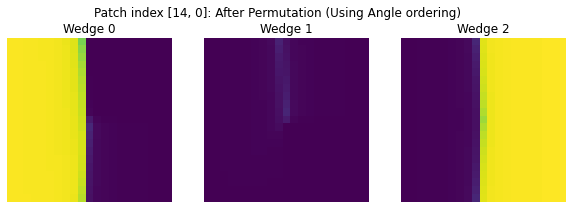

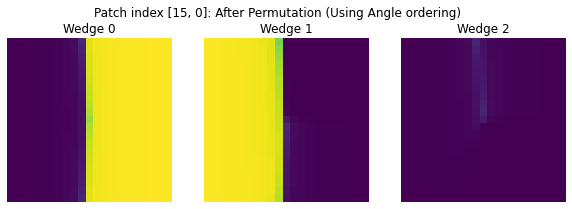

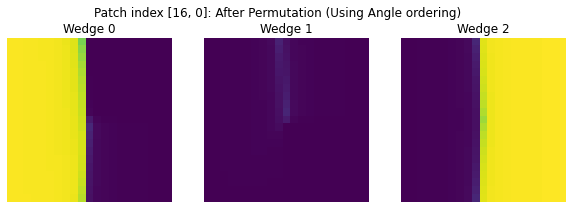

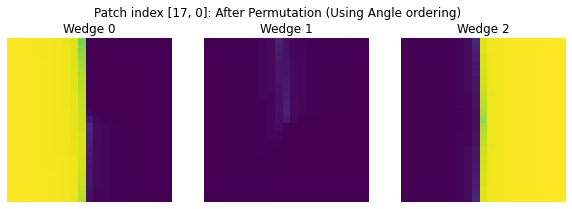

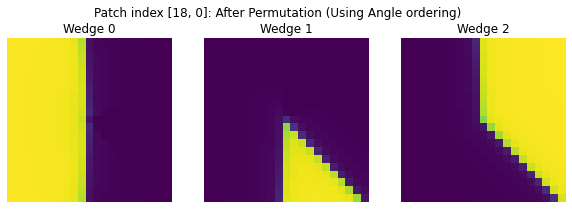

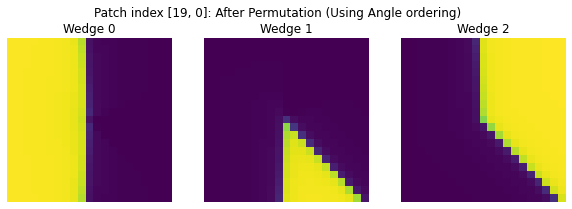

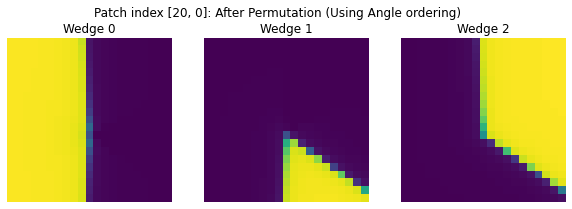

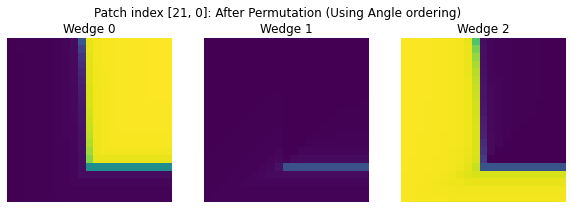

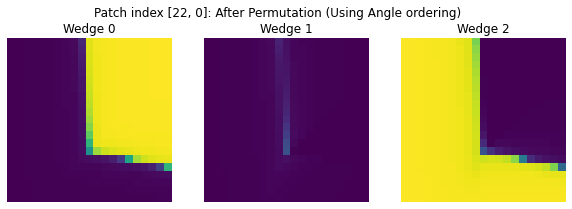

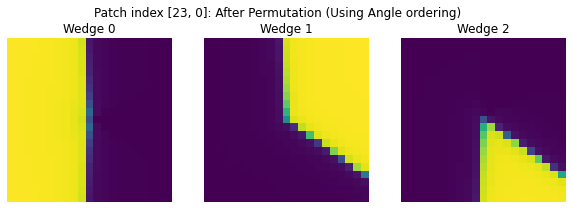

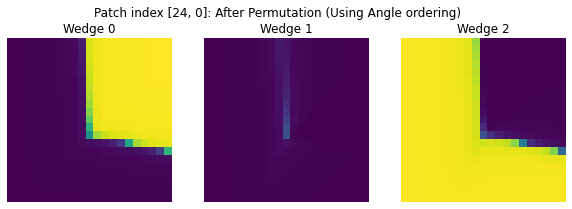

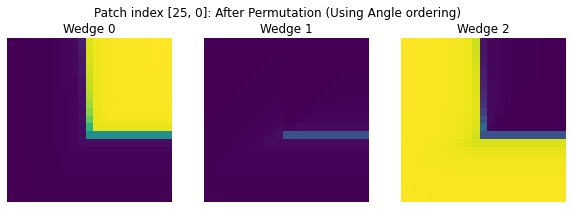

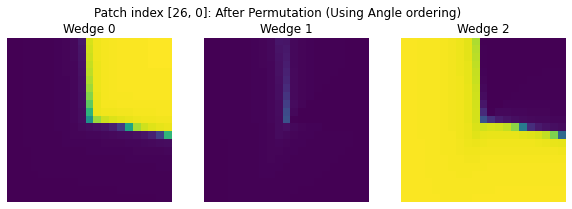

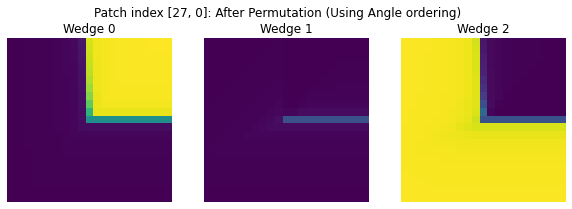

In [349]:
# @interactive
def plot_wedges(patch_idx_x =27, patch_idx_y = 0):
    patch_index = [patch_idx_x,patch_idx_y]
    plt.figure(figsize=[10,30])
    plt.suptitle(f'Patch index {patch_index}: After Permutation (Using Angle ordering)')
    plt.subplot(131)
    plt.imshow(ang_perm_wedges_unary[0,0,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
    plt.title('Wedge 0')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(ang_perm_wedges_unary[0,1,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
    plt.title('Wedge 1')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(ang_perm_wedges_unary[0,2,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
    plt.title('Wedge 2')
    plt.axis('off')
    plt.subplots_adjust(top=1.73)

for itr in range(28):
    plot_wedges(patch_idx_x =itr, patch_idx_y = 0)

In [325]:
def reconstruct_img(out,H,W,stride,PSZ):
    rec = np.zeros([H,W,int(out.shape[-2]*out.shape[-1])])
    num_overlaps = np.zeros([H,W])
    itr = 0
    for i in range(out.shape[-2]):
        for j in range(out.shape[-1]):
            rec[i*stride:i*stride + PSZ,j*stride:j*stride + PSZ,itr] = out[...,i,j].detach().cpu().numpy()
            num_overlaps[i*stride:i*stride + PSZ,j*stride:j*stride + PSZ] += 1
            itr = itr+1
    return np.divide(np.sum(rec,axis = -1),num_overlaps)


In [326]:
ang_perm_wedges_unary[0,0,...].shape

torch.Size([21, 21, 28, 28])

In [327]:
wedge_out_unary_1 = reconstruct_img(ang_perm_wedges_unary[0,0,...],48,48,opts.stride,opts.R)
wedge_out_1 =  reconstruct_img(ang_perm_wedges[0,0,...],48,48,opts.stride,opts.R)

Text(0.5, 1.0, 'Without Unary Potentials')

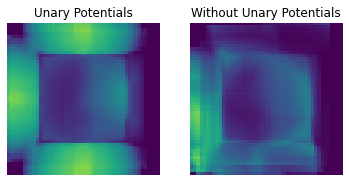

In [328]:
plt.subplot(121)
plt.imshow(wedge_out_unary_1,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Unary Potentials')
plt.subplot(122)
plt.imshow(wedge_out_1,vmin=0,vmax=1)
plt.axis('off')
plt.title('Without Unary Potentials')


In [315]:
wedge_out_unary_1[40,10]

0.4519905561835251